In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [2]:
def f(x):
    return 3*x**2 - 4*x + 5

In [3]:
f(3.0)

20.0

In [36]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None  # Function to compute the gradient
        self._prev = set(_children)  # Previous nodes in the computation graph
        self._op = _op  # Operation that produced this value
        self.label = label  # Optional label for the value

    def __repr__(self):
        # Print out the value in a readable format
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        out = Value(self.data + other.data, _children=(self, other), _op='+')
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out
    
    def __mul__(self, other):
        out = Value(self.data * other.data, _children=(self, other), _op='*')
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out

    def tanh(self):
        out = Value(math.tanh(self.data), _children=(self,), _op='tanh')
        def _backward():
            self.grad = (1 - out.data**2) * out.grad
        out._backward = _backward
        return out
    
    def backward(self):

        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1.0  # Initialize the gradient of the output node
        for node in reversed(topo):
            node._backward()

In [37]:
# Test basic operations of class
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e+c; d.label = 'd'
f = Value(-2.0, label='f')
L = d*f; L.label = 'L'

In [19]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})
    nodes, edges = trace(root)
    for n in nodes:
        dot.node(str(id(n)), label="{ %s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    for a, b in edges:
        dot.edge(str(id(a)), str(id(b)) + b._op)
    return dot

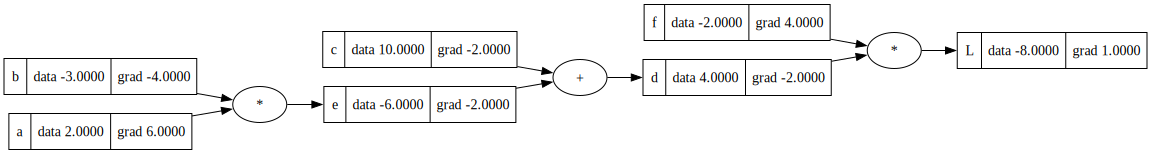

In [38]:
L.backward()
draw_dot(L)

In [31]:
L.grad = 1.0

topo = []
visited = set()
def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)
build_topo(L)

for node in reversed(topo):
    node._backward()

In [30]:
# topological sort
topo = []
visited = set()
def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)
build_topo(L)
topo

[Value(data=10.0),
 Value(data=2.0),
 Value(data=-3.0),
 Value(data=-6.0),
 Value(data=4.0),
 Value(data=-2.0),
 Value(data=-8.0)]